In [1]:
import numpy as np 
import pandas as pd 
import torch
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import time
import copy
import pickle
# Classifier Libraries
from sklearn.ensemble import IsolationForest
import collections
from sklearn.svm import  SVC
from sklearn.tree import  DecisionTreeClassifier
from sklearn.linear_model import  LogisticRegression
from sklearn.neighbors import  KNeighborsClassifier
import xgboost as xgb
import lightgbm as lgb
# train/test split libraries and preprocessing
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline

# libraries to handle imbalanced datasets
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, balanced_accuracy_score, cohen_kappa_score, average_precision_score
from collections import Counter
import shap

/home/pratyush/miniconda3/envs/cvpr/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('paysim/PS_20174392719_1491204439457_log.csv')
df = df.rename(columns = {'nameOrig' : 'origin', 'oldbalanceOrg' : 'sender_old_balance', 'newbalanceOrig': 'sender_new_balance', 'nameDest' : 'destination', 'oldbalanceDest' : 'receiver_old_balance', 'newbalanceDest': 'receiver_new_balance', 'isFraud' : 'isfraud'})[:100000]
df = df.drop(columns = ['step', 'isFlaggedFraud'], axis = 'columns')
cols = df.columns.tolist()
new_position = 3

cols.insert(new_position, cols.pop(cols.index('destination')))
df = df[cols]

In [3]:
df

,type,amount,origin,destination,sender_old_balance,sender_new_balance,receiver_old_balance,receiver_new_balance,isfraud
0,PAYMENT,9839.64,C1231006815,M1979787155,170136.0,160296.36,0.00,0.00,0
1,PAYMENT,1864.28,C1666544295,M2044282225,21249.0,19384.72,0.00,0.00,0
2,TRANSFER,181.00,C1305486145,C553264065,181.0,0.00,0.00,0.00,1
3,CASH_OUT,181.00,C840083671,C38997010,181.0,0.00,21182.00,0.00,1
4,PAYMENT,11668.14,C2048537720,M1230701703,41554.0,29885.86,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...
99995,PAYMENT,4020.66,C1410794718,M1257036576,159929.0,155908.34,0.00,0.00,0
99996,PAYMENT,18345.49,C744303677,M1785344556,6206.0,0.00,0.00,0.00,0
99997,CASH_IN,183774.91,C104331851,C36392889,39173.0,222947.91,54925.05,0.00,0
99998,CASH_OUT,82237.17,C707662966,C1553004158,6031.0,0.00,592635.66,799140.46,0


In [10]:
df['isfraud'].value_counts()

isfraud
0    99884
1      116
Name: count, dtype: int64

In [4]:
data = df.copy()
data['type2'] = np.nan
data.loc[df.origin.str.contains('C') & df.destination.str.contains('C'), 'type2'] = 'CC'
data.loc[df.origin.str.contains('C') & df.destination.str.contains('M'), 'type2'] = 'CM'
data.loc[df.origin.str.contains('M') & df.destination.str.contains('C'), 'type2'] = 'MC'
data.loc[df.origin.str.contains('M') & df.destination.str.contains('C'), 'type2'] = 'MM'

In [5]:
data

,type,amount,origin,destination,sender_old_balance,sender_new_balance,receiver_old_balance,receiver_new_balance,isfraud,type2
0,PAYMENT,9839.64,C1231006815,M1979787155,170136.0,160296.36,0.00,0.00,0,CM
1,PAYMENT,1864.28,C1666544295,M2044282225,21249.0,19384.72,0.00,0.00,0,CM
2,TRANSFER,181.00,C1305486145,C553264065,181.0,0.00,0.00,0.00,1,CC
3,CASH_OUT,181.00,C840083671,C38997010,181.0,0.00,21182.00,0.00,1,CC
4,PAYMENT,11668.14,C2048537720,M1230701703,41554.0,29885.86,0.00,0.00,0,CM
...,...,...,...,...,...,...,...,...,...,...
99995,PAYMENT,4020.66,C1410794718,M1257036576,159929.0,155908.34,0.00,0.00,0,CM
99996,PAYMENT,18345.49,C744303677,M1785344556,6206.0,0.00,0.00,0.00,0,CM
99997,CASH_IN,183774.91,C104331851,C36392889,39173.0,222947.91,54925.05,0.00,0,CC
99998,CASH_OUT,82237.17,C707662966,C1553004158,6031.0,0.00,592635.66,799140.46,0,CC


In [6]:
cols = data.columns.tolist()
new_position = 1

cols.insert(new_position, cols.pop(cols.index('type2')))
data = data[cols]
data.drop(columns = ['origin','destination'], axis = 'columns', inplace = True)

fraud_trans = data[data['isfraud'] == 1]
valid_trans = data[data['isfraud'] == 0]

print('Number of fraud transactions according to type are below:\n', fraud_trans.type2.value_counts(), '\n')
print('Number of valid transactions according to type are below:\n', valid_trans.type2.value_counts())

Number of fraud transactions according to type are below:
 type2
CC    116
Name: count, dtype: int64 

Number of valid transactions according to type are below:
 type2
CC    60372
CM    39512
Name: count, dtype: int64



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
data

,type,type2,amount,sender_old_balance,sender_new_balance,receiver_old_balance,receiver_new_balance,isfraud
0,PAYMENT,CM,9839.64,170136.0,160296.36,0.00,0.00,0
1,PAYMENT,CM,1864.28,21249.0,19384.72,0.00,0.00,0
2,TRANSFER,CC,181.00,181.0,0.00,0.00,0.00,1
3,CASH_OUT,CC,181.00,181.0,0.00,21182.00,0.00,1
4,PAYMENT,CM,11668.14,41554.0,29885.86,0.00,0.00,0
...,...,...,...,...,...,...,...,...
99995,PAYMENT,CM,4020.66,159929.0,155908.34,0.00,0.00,0
99996,PAYMENT,CM,18345.49,6206.0,0.00,0.00,0.00,0
99997,CASH_IN,CC,183774.91,39173.0,222947.91,54925.05,0.00,0
99998,CASH_OUT,CC,82237.17,6031.0,0.00,592635.66,799140.46,0


In [8]:
data = pd.get_dummies(data, prefix = ['type', 'type2'], drop_first = True)

In [14]:
pd.__version__

'2.0.3'

In [9]:
data

,amount,sender_old_balance,sender_new_balance,receiver_old_balance,receiver_new_balance,isfraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,type2_CM
0,9839.64,170136.0,160296.36,0.00,0.00,0,False,False,True,False,True
1,1864.28,21249.0,19384.72,0.00,0.00,0,False,False,True,False,True
2,181.00,181.0,0.00,0.00,0.00,1,False,False,False,True,False
3,181.00,181.0,0.00,21182.00,0.00,1,True,False,False,False,False
4,11668.14,41554.0,29885.86,0.00,0.00,0,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...
99995,4020.66,159929.0,155908.34,0.00,0.00,0,False,False,True,False,True
99996,18345.49,6206.0,0.00,0.00,0.00,0,False,False,True,False,True
99997,183774.91,39173.0,222947.91,54925.05,0.00,0,False,False,False,False,False
99998,82237.17,6031.0,0.00,592635.66,799140.46,0,True,False,False,False,False


In [14]:
data

,amount,sender_old_balance,sender_new_balance,receiver_old_balance,receiver_new_balance,isfraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,type2_CM
0,9839.64,170136.0,160296.36,0.00,0.00,0,False,False,True,False,True
1,1864.28,21249.0,19384.72,0.00,0.00,0,False,False,True,False,True
2,181.00,181.0,0.00,0.00,0.00,1,False,False,False,True,False
3,181.00,181.0,0.00,21182.00,0.00,1,True,False,False,False,False
4,11668.14,41554.0,29885.86,0.00,0.00,0,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...
99995,4020.66,159929.0,155908.34,0.00,0.00,0,False,False,True,False,True
99996,18345.49,6206.0,0.00,0.00,0.00,0,False,False,True,False,True
99997,183774.91,39173.0,222947.91,54925.05,0.00,0,False,False,False,False,False
99998,82237.17,6031.0,0.00,592635.66,799140.46,0,True,False,False,False,False


In [11]:
X = data.drop(columns=['isfraud'])
y = data.isfraud

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, stratify = data.isfraud)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [12]:
rfc=RandomForestClassifier(n_estimators = 15, n_jobs = -1, random_state = 42)
lgbm = lgb.LGBMClassifier(boosting_type = 'gbdt',objective = 'binary', random_state = 8888)
xgbr = xgb.XGBClassifier(max_depth = 3, n_jobs = -1, random_state = 42, learning_rate = 0.1)
logreg = LogisticRegression(solver = 'liblinear', random_state = 42)
dtc = DecisionTreeClassifier()

rfc.fit(X_train, y_train)
lgbm.fit(X_train, y_train)
xgbr.fit(X_train, y_train)
logreg.fit(X_train, y_train)
dtc.fit(X_train,y_train)

classifiers = []
classifiers.append(rfc)
classifiers.append(lgbm)
classifiers.append(xgbr)
classifiers.append(logreg)
classifiers.append(dtc)

[LightGBM] [Info] Number of positive: 81, number of negative: 69919
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1290
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001157 -> initscore=-6.760644
[LightGBM] [Info] Start training from score -6.760644


[16:05:36] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


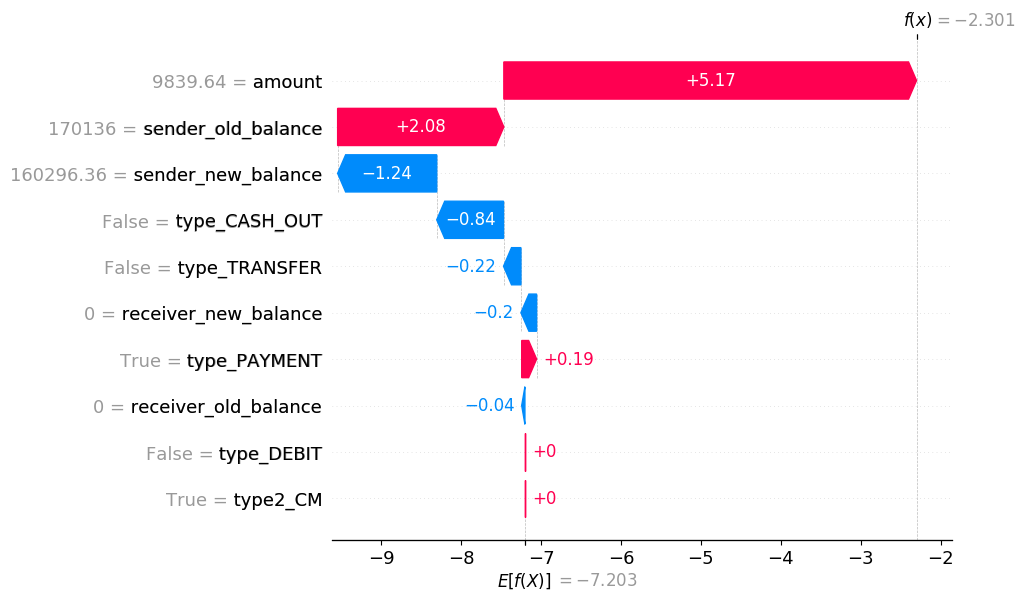

In [13]:
explainer = shap.Explainer(xgbr)
shap_values = explainer(X)
shap.plots.waterfall(shap_values[0])

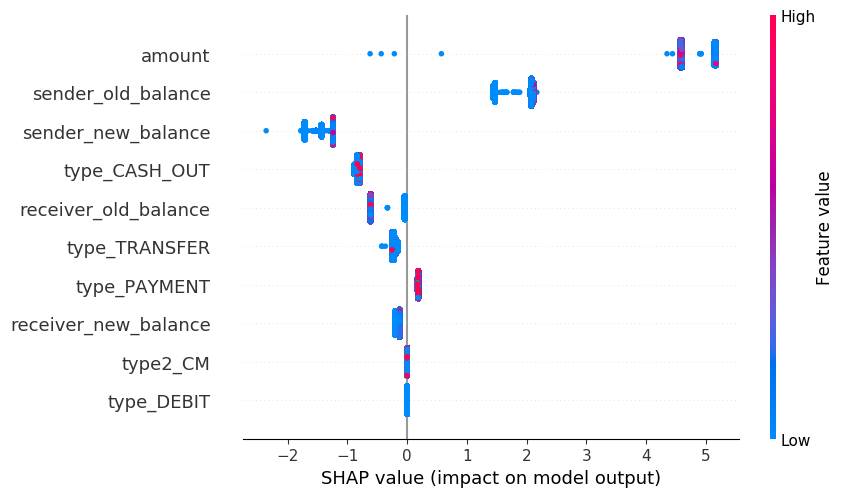

In [20]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

In [22]:
X_train

array([[-0.50044422, -0.2796766 , -0.28236783, ...,  1.23114714,
        -0.30668828,  1.23114714],
       [-0.4893415 , -0.31289544, -0.31652119, ...,  1.23114714,
        -0.30668828,  1.23114714],
       [-0.49185529, -0.30469241, -0.30811606, ...,  1.23114714,
        -0.30668828,  1.23114714],
       ...,
       [-0.4940083 , -0.32658283, -0.32804052, ...,  1.23114714,
        -0.30668828,  1.23114714],
       [-0.42621794, -0.32658283, -0.32804052, ..., -0.8122506 ,
        -0.30668828, -0.8122506 ],
       [-0.4497095 , -0.32658283, -0.32804052, ...,  1.23114714,
        -0.30668828,  1.23114714]])

In [ ]:
print(classification_rep)

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00   1906322
           1       0.00      0.26      0.00      2464

    accuracy                           0.00   1908786
   macro avg       0.00      0.09      0.00   1908786
weighted avg       0.00      0.00      0.00   1908786



In [18]:
accuracy_list = []
auc_list = []

for classifier in classifiers:
    y_pred = classifier.predict(X_test)
    y_pred_proba = classifier.predict_proba(X_test)[:,1]
    accuracy_list.append(accuracy_score(y_test, y_pred))
    auc_list.append(roc_auc_score(y_test, y_pred_proba))

accuracy_dict = {}
auc_dict = {}
for i in range(4):
    key=['Random Forest', 'Light GBM', 'XGBoost','LR', 'Decision Tree'][i]
    accuracy_dict[key] = accuracy_list[i]
    auc_dict[key] = auc_list[i]
    
accuracy_dict_sorted = dict(sorted(accuracy_dict.items(), key = lambda item: item[1]))
auc_dict_sorted = dict(sorted(auc_dict.items(), key = lambda item: item[1]))

In [19]:
accuracy_list,auc_list

([0.9992666666666666,
  0.9978333333333333,
  0.9992666666666666,
  0.9989,
  0.9989333333333333],
 [0.8560358513503851,
  0.8544983433052847,
  0.9853524349836714,
  0.912648566184358,
  0.7140854806798408])

In [64]:
for i, classifier in enumerate(classifiers):
    with open(f'model_{i+1}.pkl', 'wb') as file:
        pickle.dump(classifier, file)

In [15]:
knn= KNeighborsClassifier(n_neighbors=2)
svc = SVC(kernel='poly')
iso_forest = IsolationForest(n_estimators=20)

knn.fit(X_train,y_train)
svc.fit(X_train,y_train)
iso_forest.fit(X_train)


uns_classifiers = []
uns_classifiers.append(knn)
uns_classifiers.append(svc)
uns_classifiers.append(iso_forest)

In [ ]:
accuracy_uns_list = []
auc_uns_list = []

for classifier in uns_classifiers:
    y_pred = classifier.predict(X_test)
    y_pred_proba = classifier.predict_proba(X_test)[:,1]
    accuracy_list.append(accuracy_score(y_test, y_pred))
    auc_list.append(roc_auc_score(y_test, y_pred_proba))

accuracy_dict = {}
auc_dict = {}
for i in range(4):
    key=['knn','svc','IsolationForest'][i]
    accuracy_dict[key] = accuracy_list[i]
    auc_dict[key] = auc_list[i]
    
accuracy_dict_sorted = dict(sorted(accuracy_dict.items(), key = lambda item: item[1]))
auc_dict_sorted = dict(sorted(auc_dict.items(), key = lambda item: item[1]))